# Models Fusion

## Set up

###  Install required packages.

In [76]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install optuna

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-b9oapfgd
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-b9oapfgd
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 4410298df8de8ca9f13ba4ee12e6a30ec82c42d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.4 MB/s eta 0:00:00


### Unzip Data and Utils

In [2]:
!unzip "utils.zip" -d '.'

Archive:  utils.zip
   creating: ./utils/
   creating: ./utils/__pycache__/
  inflating: ./__MACOSX/utils/.___pycache__  
  inflating: ./utils/threshold.py    
  inflating: ./utils/comparing.py    
  inflating: ./utils/__pycache__/comparing.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._comparing.cpython-312.pyc  
  inflating: ./utils/__pycache__/threshold.cpython-312.pyc  
  inflating: ./__MACOSX/utils/__pycache__/._threshold.cpython-312.pyc  


In [3]:
!unzip "data.zip" -d '.'

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2024-5-2-NovaMind/._@openzeppelin  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-11-25-Sloth Inu/._0x85bcaee8befa419becb90e8b405d131ee9e31877.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2021-8-26-Snakedefi/._0xf882413338a88F3d41f0df4c31d8CA5d33e3e3d1.sol  
  inflating: ./data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/0x9bc699780A326C059C660C6ee2EF1D8583D01aEa.sol  
  inflating: ./__MACOSX/data/external/rphunter/Dataset/Incidents-Source-Code/2022-9-22-SiriusToken/._0x9bc699780A326C05

### Import and Var

In [135]:
import warnings
warnings.filterwarnings("ignore")

In [136]:
import os
import pandas as pd
from pathlib import Path
import json
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.utils import from_networkx

from utils.comparing import report_for_multiple_model_as_same_set, evaluate_multilabel_classification
from utils.threshold import tune_thresholds

PATH = './data/labeled'

## Load Data

In [137]:
def load_feature(file):
    df = pd.read_csv(os.path.join(PATH, file), index_col=0)
    df.index = df.index.str.lower()
    return df

In [138]:
def plot_confusion_matrix(y_test, y_pred):
    print(classification_report(y_test, y_pred, target_names=label_cols))
    mcm = multilabel_confusion_matrix(y_test, y_pred)

    n_labels = len(label_cols)
    fig, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 4))  # 5 units wide per plot

    for i, matrix in enumerate(mcm):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No ' + label_cols[i], label_cols[i]])
        disp.plot(cmap=plt.cm.Blues, ax=axes[i], colorbar=False)
        axes[i].set_title(f'{label_cols[i]}')

    plt.show()

In [139]:
y = load_feature('groundtruth.csv')
label_cols = [col for col in y.columns]
y.index = y.index.str.lower()
addresses = y.index.tolist()

### Split Train

In [140]:
train_idx, test_idx = train_test_split(addresses, test_size=0.3, random_state=42)
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

## Individual Model

In [141]:
# for txn static, bytecode
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# for source code
from sklearn.linear_model import LogisticRegression

# tuning
import optuna
from sklearn.metrics import f1_score

### Txn Static Feature Model

#### Base

In [142]:
df = load_feature('transaction_feature.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
train_idx_filtered = [idx for idx in train_idx if idx in df.index]
test_idx_filtered = [idx for idx in test_idx if idx in df.index]

X_train = df.loc[train_idx_filtered]
X_test = df.loc[test_idx_filtered]
y_train_filtered = y_train.loc[train_idx_filtered]
y_test_filtered = y_test.loc[test_idx_filtered]

In [143]:
txn_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
txn_model.fit(X_train, y_train_filtered)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       1.00      0.12      0.22         8
        Leak       0.30      0.75      0.43         4
       Limit       0.73      0.67      0.70        12

   micro avg       0.55      0.50      0.52        24
   macro avg       0.68      0.51      0.45        24
weighted avg       0.75      0.50      0.49        24
 samples avg       0.33      0.34      0.32        24



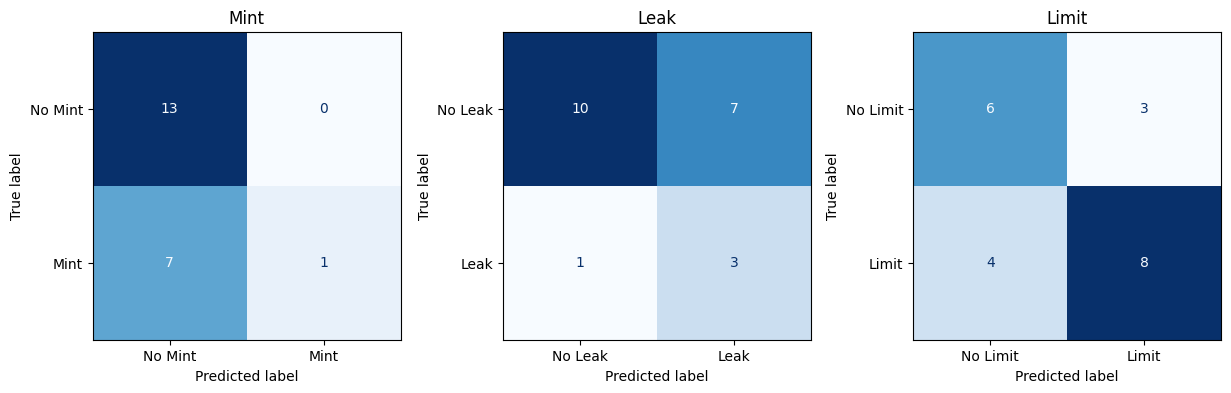

In [144]:
y_pred = txn_model.predict(X_test)
plot_confusion_matrix(y_test_filtered, y_pred)

#### Tuning

In [145]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **params))
    clf.fit(X_train, y_train_filtered)
    y_pred = clf.predict(X_test)
    return f1_score(y_test_filtered, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 17:41:37,071] A new study created in memory with name: no-name-e915ff5e-2bf3-49f8-b428-ca4f837f6dbb
[I 2025-07-28 17:41:38,063] Trial 0 finished with value: 0.441407867494824 and parameters: {'n_estimators': 138, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.441407867494824.
[I 2025-07-28 17:41:39,211] Trial 1 finished with value: 0.441407867494824 and parameters: {'n_estimators': 152, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.441407867494824.
[I 2025-07-28 17:41:40,546] Trial 2 finished with value: 0.441407867494824 and parameters: {'n_estimators': 213, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.441407867494824.
[I 2025-07-28 17:41:41,203] Trial 3 finished with value: 0.441407867494824 and parameters: {'n_estimators': 131, 'max_depth': 25, 'min_samp

Best Params: {'n_estimators': 132, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best Score: 0.4488152749022314


In [146]:
tuned_txn_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **study.best_params))
tuned_txn_model.fit(X_train, y_train_filtered)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=25,
                                                       n_estimators=132,
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       1.00      0.12      0.22         8
        Leak       0.30      0.75      0.43         4
       Limit       0.73      0.67      0.70        12

   micro avg       0.55      0.50      0.52        24
   macro avg       0.68      0.51      0.45        24
weighted avg       0.75      0.50      0.49        24
 samples avg       0.33      0.34      0.32        24



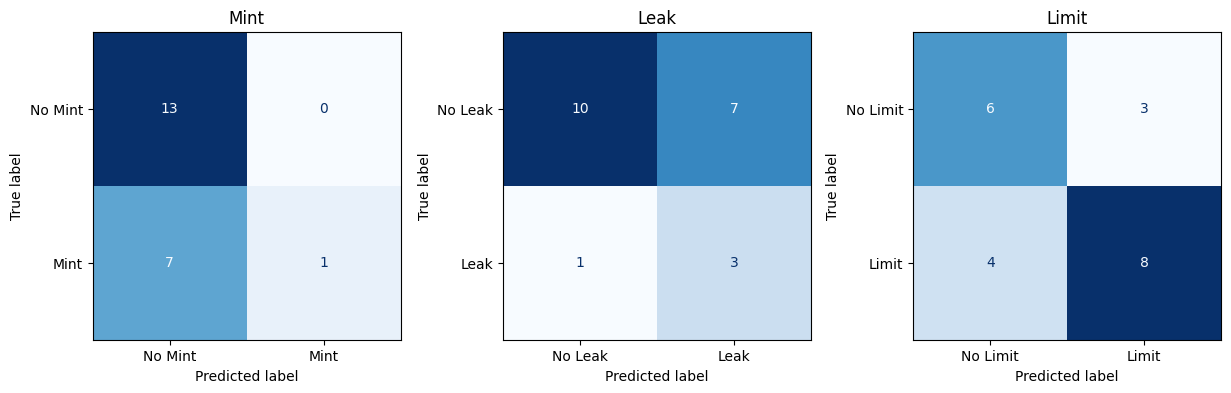

In [147]:
y_pred = tuned_txn_model.predict(X_test)
plot_confusion_matrix(y_test_filtered, y_pred)

### Bytecode Static Feature Model

#### Base

In [148]:
df = load_feature('bytecode_feature.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
train_idx_filtered = [idx for idx in train_idx if idx in df.index]
test_idx_filtered = [idx for idx in test_idx if idx in df.index]

X_train = df.loc[train_idx_filtered]
X_test = df.loc[test_idx_filtered]
y_train_filtered = y_train.loc[train_idx_filtered]
y_test_filtered = y_test.loc[test_idx_filtered]

In [149]:
byte_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
byte_model.fit(X_train, y_train_filtered)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.60      0.38      0.46         8
        Leak       1.00      0.25      0.40         4
       Limit       0.78      0.58      0.67        12

   micro avg       0.73      0.46      0.56        24
   macro avg       0.79      0.40      0.51        24
weighted avg       0.76      0.46      0.55        24
 samples avg       0.37      0.36      0.35        24



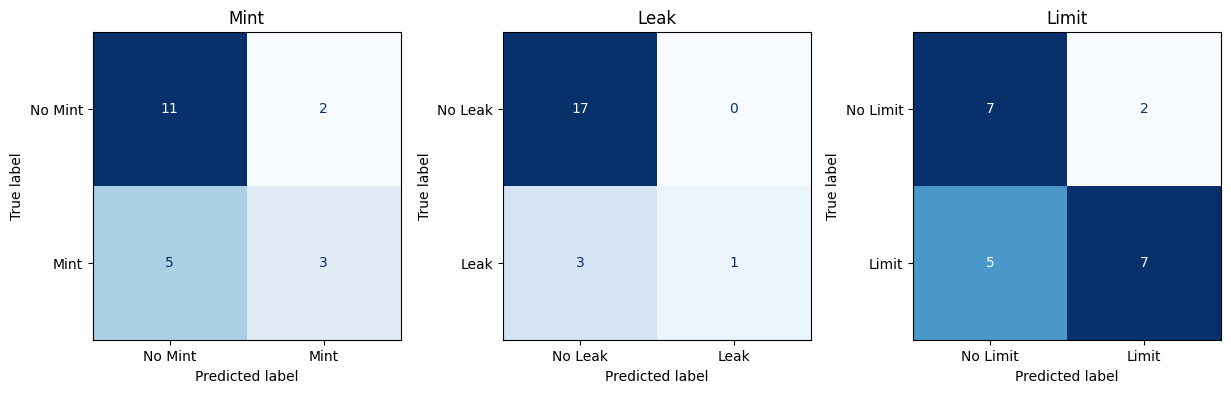

In [150]:
y_pred = byte_model.predict(X_test)
plot_confusion_matrix(y_test_filtered, y_pred)

#### Tuning

In [151]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }

    clf = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **params))
    clf.fit(X_train, y_train_filtered)
    y_pred = clf.predict(X_test)
    return f1_score(y_test_filtered, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 17:42:22,754] A new study created in memory with name: no-name-77b7ea4f-b66a-497f-9d13-b91d725fad47
[I 2025-07-28 17:42:23,448] Trial 0 finished with value: 0.4871794871794872 and parameters: {'n_estimators': 127, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.4871794871794872.
[I 2025-07-28 17:42:24,224] Trial 1 finished with value: 0.4871794871794872 and parameters: {'n_estimators': 152, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.4871794871794872.
[I 2025-07-28 17:42:24,871] Trial 2 finished with value: 0.5760683760683761 and parameters: {'n_estimators': 119, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5760683760683761.
[I 2025-07-28 17:42:26,149] Trial 3 finished with value: 0.4871794871794872 and parameters: {'n_estimators': 243, 'max_depth': 30, 'm

Best Params: {'n_estimators': 119, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
Best Score: 0.5760683760683761


In [152]:
tuned_byte_model = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', random_state=42, **study.best_params))
tuned_byte_model.fit(X_train, y_train_filtered)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=17,
                                                       min_samples_leaf=3,
                                                       min_samples_split=7,
                                                       n_estimators=119,
                                                       random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.60      0.38      0.46         8
        Leak       1.00      0.50      0.67         4
       Limit       0.75      0.50      0.60        12

   micro avg       0.73      0.46      0.56        24
   macro avg       0.78      0.46      0.58        24
weighted avg       0.74      0.46      0.56        24
 samples avg       0.37      0.36      0.35        24



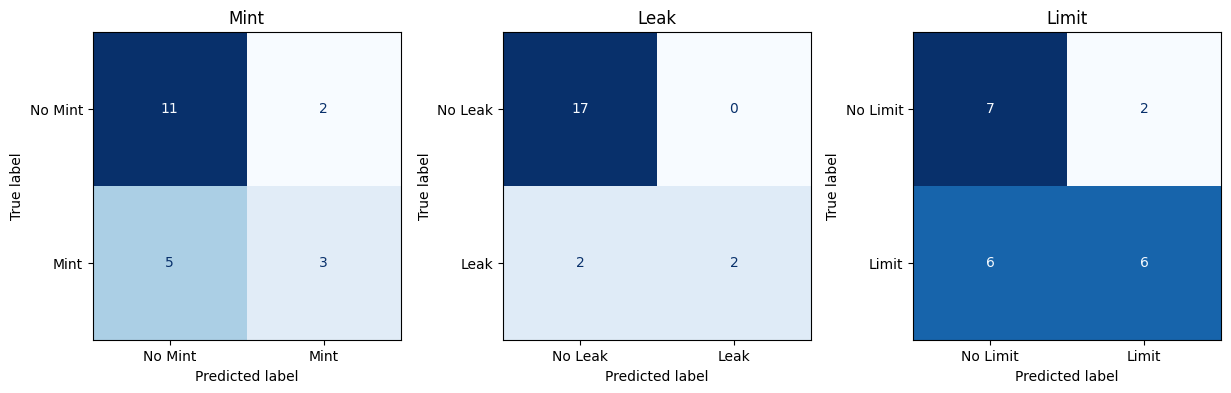

In [153]:
y_pred = tuned_byte_model.predict(X_test)
plot_confusion_matrix(y_test_filtered, y_pred)

### Source Code Static Feature Model

#### Base

In [154]:
df = load_feature('tf_idf.csv')

# Filter train_idx and test_idx to include only addresses present in df.index
train_idx_filtered = [idx for idx in train_idx if idx in df.index]
test_idx_filtered = [idx for idx in test_idx if idx in df.index]

X_train = df.loc[train_idx_filtered]
X_test = df.loc[test_idx_filtered]
y_train_filtered = y_train.loc[train_idx_filtered]
y_test_filtered = y_test.loc[test_idx_filtered]

In [155]:
source_model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42))
source_model.fit(X_train, y_train_filtered)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   random_state=42))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.50      0.86      0.63         7
        Leak       1.00      0.25      0.40         4
       Limit       0.75      0.55      0.63        11

   micro avg       0.62      0.59      0.60        22
   macro avg       0.75      0.55      0.55        22
weighted avg       0.72      0.59      0.59        22
 samples avg       0.50      0.43      0.44        22



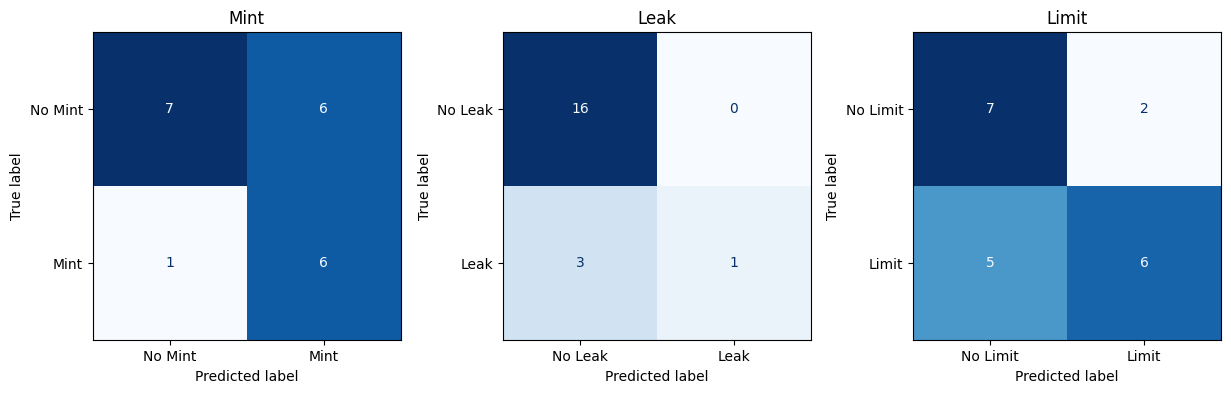

In [156]:
y_pred = source_model.predict(X_test)
plot_confusion_matrix(y_test_filtered, y_pred)

#### Tuning

In [157]:
def objective(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-3, 10, log=True),  # regularization strength
        "solver": trial.suggest_categorical(
            "solver", ["liblinear", "saga"]  # both support l1 and l2
        ),
        "max_iter": 1000
    }

    clf = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42, **params))
    clf.fit(X_train, y_train_filtered)
    y_pred = clf.predict(X_test)
    return f1_score(y_test_filtered, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 17:43:19,314] A new study created in memory with name: no-name-1259c741-1170-4266-82c6-0f49a35ce0e2
[I 2025-07-28 17:43:19,822] Trial 0 finished with value: 0.593859649122807 and parameters: {'penalty': 'l2', 'C': 2.7030709192395617, 'solver': 'saga'}. Best is trial 0 with value: 0.593859649122807.
[I 2025-07-28 17:43:20,116] Trial 1 finished with value: 0.5087719298245613 and parameters: {'penalty': 'l2', 'C': 0.10821866557397626, 'solver': 'saga'}. Best is trial 0 with value: 0.593859649122807.
[I 2025-07-28 17:43:20,260] Trial 2 finished with value: 0.5238095238095238 and parameters: {'penalty': 'l2', 'C': 0.07428475968124007, 'solver': 'liblinear'}. Best is trial 0 with value: 0.593859649122807.
[I 2025-07-28 17:43:20,410] Trial 3 finished with value: 0.34767025089605735 and parameters: {'penalty': 'l1', 'C': 0.0034268212812643283, 'solver': 'saga'}. Best is trial 0 with value: 0.593859649122807.
[I 2025-07-28 17:43:20,835] Trial 4 finished with value: 0.5333333333333

Best Params: {'penalty': 'l2', 'C': 3.3812082717306393, 'solver': 'saga'}
Best Score: 0.6295739348370927


In [158]:
tuned_source_model = MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=42, **study.best_params))
tuned_source_model.fit(X_train, y_train_filtered)

MultiOutputClassifier(estimator=LogisticRegression(C=3.3812082717306393,
                                                   class_weight='balanced',
                                                   random_state=42,
                                                   solver='saga'))

##### Evaluation

              precision    recall  f1-score   support

        Mint       0.86      0.86      0.86         7
        Leak       1.00      0.25      0.40         4
       Limit       0.75      0.55      0.63        11

   micro avg       0.81      0.59      0.68        22
   macro avg       0.87      0.55      0.63        22
weighted avg       0.83      0.59      0.66        22
 samples avg       0.53      0.43      0.46        22



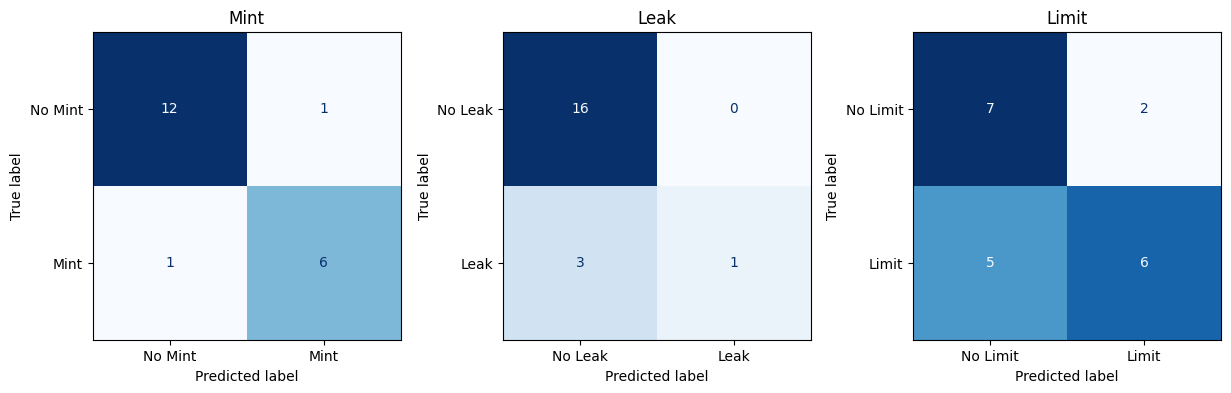

In [159]:
y_pred = tuned_source_model.predict(X_test)
plot_confusion_matrix(y_test_filtered, y_pred)

### Transaction Time Series

#### import lib

In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

#### load data

In [161]:
seq_len = 500
feature_dim = 5

X_train, X_test, y_train_filtered, y_test_filtered  = [], [], [], []

for path in tqdm(list(Path(os.path.join(PATH, 'txn')).glob('*.json'))):
    addr = path.stem
    data = json.load(open(path, 'r'))
    txns = sorted(data.get("transaction", []), key=lambda x: int(x.get("timeStamp", 0)))
    seq = [[
        int(tx.get("gas", 0)),
        int(tx.get("gasPrice", 0)),
        int(tx.get("value", 0)),
        int(tx.get("isError", 0)),
        int(tx.get("txreceipt_status", 0))
    ] for tx in txns]

    if len(seq) < seq_len:
        seq += [[0]*feature_dim] * (seq_len - len(seq))
    else:
        seq = seq[:seq_len]

    seq = StandardScaler().fit_transform(seq)

    if addr in train_idx:
        X_train.append(seq)
        y_train_filtered.append(y.loc[addr].tolist())
    elif addr in test_idx:
        X_test.append(seq)
        y_test_filtered.append(y.loc[addr].tolist())

100%|██████████| 69/69 [00:00<00:00, 69.21it/s]


In [162]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train_filtered = np.array(y_train_filtered)
y_test_filtered = np.array(y_test_filtered)

#### tuning

In [163]:
epochs = 20

In [164]:
def build_gru_model(input_shape, units, lr):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        GRU(units),
        Dense(3, activation='sigmoid')  # for multilabel
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy())
    return model

In [165]:
def objective(trial):
    units = trial.suggest_int("units", 32, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    model = build_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]), units=units, lr=lr)
    model.fit(X_train, y_train_filtered, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred = model.predict(X_test)
    thresholds, _ = tune_thresholds(y_test_filtered, y_pred)

    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_test_filtered, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 17:43:41,539] A new study created in memory with name: no-name-358f9d78-850b-4018-b916-acb9ad04e26c


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Label 0: Best threshold = 0.40, Best f1 = 0.5556
Label 1: Best threshold = 0.26, Best f1 = 0.4286


[I 2025-07-28 17:44:01,351] Trial 0 finished with value: 0.5809158912607189 and parameters: {'units': 63, 'lr': 0.0011090908033141837, 'batch_size': 32}. Best is trial 0 with value: 0.5809158912607189.


Label 2: Best threshold = 0.36, Best f1 = 0.7586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Label 0: Best threshold = 0.39, Best f1 = 0.7000
Label 1: Best threshold = 0.17, Best f1 = 0.4286


[I 2025-07-28 17:44:18,716] Trial 1 finished with value: 0.6261904761904762 and parameters: {'units': 73, 'lr': 0.003907170135819385, 'batch_size': 16}. Best is trial 1 with value: 0.6261904761904762.


Label 2: Best threshold = 0.06, Best f1 = 0.7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.48, Best f1 = 0.4000


[I 2025-07-28 17:44:32,341] Trial 2 finished with value: 0.5596656217345872 and parameters: {'units': 45, 'lr': 0.0003072210334051333, 'batch_size': 64}. Best is trial 1 with value: 0.6261904761904762.


Label 2: Best threshold = 0.00, Best f1 = 0.7273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
Label 0: Best threshold = 0.36, Best f1 = 0.5714
Label 1: Best threshold = 0.45, Best f1 = 0.4211


[I 2025-07-28 17:44:49,244] Trial 3 finished with value: 0.6024320059407778 and parameters: {'units': 92, 'lr': 0.0004920202837786848, 'batch_size': 64}. Best is trial 1 with value: 0.6261904761904762.


Label 2: Best threshold = 0.49, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Label 0: Best threshold = 0.46, Best f1 = 0.5556
Label 1: Best threshold = 0.15, Best f1 = 0.4286


[I 2025-07-28 17:45:06,606] Trial 4 finished with value: 0.5899470899470899 and parameters: {'units': 52, 'lr': 0.0011515689868372022, 'batch_size': 32}. Best is trial 1 with value: 0.6261904761904762.


Label 2: Best threshold = 0.31, Best f1 = 0.7857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Label 0: Best threshold = 0.43, Best f1 = 0.5556


[I 2025-07-28 17:45:22,402] Trial 5 finished with value: 0.6153846153846154 and parameters: {'units': 43, 'lr': 0.0006025358707774524, 'batch_size': 16}. Best is trial 1 with value: 0.6261904761904762.


Label 1: Best threshold = 0.25, Best f1 = 0.4444
Label 2: Best threshold = 0.44, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
Label 0: Best threshold = 0.49, Best f1 = 0.6316
Label 1: Best threshold = 0.47, Best f1 = 0.4000


[I 2025-07-28 17:45:40,143] Trial 6 finished with value: 0.5938596491228071 and parameters: {'units': 64, 'lr': 0.0001591594363014155, 'batch_size': 32}. Best is trial 1 with value: 0.6261904761904762.


Label 2: Best threshold = 0.46, Best f1 = 0.7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Label 0: Best threshold = 0.35, Best f1 = 0.6000
Label 1: Best threshold = 0.23, Best f1 = 0.4444


[I 2025-07-28 17:45:51,865] Trial 7 finished with value: 0.6045584045584045 and parameters: {'units': 36, 'lr': 0.002358841332542913, 'batch_size': 64}. Best is trial 1 with value: 0.6261904761904762.


Label 2: Best threshold = 0.30, Best f1 = 0.7692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Label 0: Best threshold = 0.15, Best f1 = 0.5714
Label 1: Best threshold = 0.09, Best f1 = 0.4286


[I 2025-07-28 17:46:07,815] Trial 8 finished with value: 0.6 and parameters: {'units': 73, 'lr': 0.0024690359252963036, 'batch_size': 64}. Best is trial 1 with value: 0.6261904761904762.


Label 2: Best threshold = 0.25, Best f1 = 0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Label 0: Best threshold = 0.42, Best f1 = 0.7619
Label 1: Best threshold = 0.16, Best f1 = 0.4286


[I 2025-07-28 17:46:33,464] Trial 9 finished with value: 0.6684303350970017 and parameters: {'units': 112, 'lr': 0.004255311236930705, 'batch_size': 64}. Best is trial 9 with value: 0.6684303350970017.


Label 2: Best threshold = 0.04, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Label 0: Best threshold = 0.14, Best f1 = 0.7619


[I 2025-07-28 17:47:02,358] Trial 10 finished with value: 0.673721340388007 and parameters: {'units': 124, 'lr': 0.006672249984169066, 'batch_size': 64}. Best is trial 10 with value: 0.673721340388007.


Label 1: Best threshold = 0.06, Best f1 = 0.4444
Label 2: Best threshold = 0.13, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Label 0: Best threshold = 0.08, Best f1 = 0.6667
Label 1: Best threshold = 0.06, Best f1 = 0.4444


[I 2025-07-28 17:47:30,233] Trial 11 finished with value: 0.6524216524216525 and parameters: {'units': 123, 'lr': 0.009642910428262846, 'batch_size': 64}. Best is trial 10 with value: 0.673721340388007.


Label 2: Best threshold = 0.12, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Label 0: Best threshold = 0.11, Best f1 = 0.7273
Label 1: Best threshold = 0.09, Best f1 = 0.5000


[I 2025-07-28 17:47:57,323] Trial 12 finished with value: 0.6911421911421911 and parameters: {'units': 127, 'lr': 0.008795322654422618, 'batch_size': 64}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.13, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Label 0: Best threshold = 0.36, Best f1 = 0.7000
Label 1: Best threshold = 0.09, Best f1 = 0.4706
Label 2: Best threshold = 0.29, Best f1 = 0.8148


[I 2025-07-28 17:48:15,395] Trial 13 finished with value: 0.6618010167029774 and parameters: {'units': 103, 'lr': 0.00865889919217008, 'batch_size': 64}. Best is trial 12 with value: 0.6911421911421911.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Label 0: Best threshold = 0.25, Best f1 = 0.7000


[I 2025-07-28 17:48:45,207] Trial 14 finished with value: 0.6618010167029774 and parameters: {'units': 126, 'lr': 0.005604246452976029, 'batch_size': 64}. Best is trial 12 with value: 0.6911421911421911.


Label 1: Best threshold = 0.15, Best f1 = 0.4706
Label 2: Best threshold = 0.14, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Label 0: Best threshold = 0.12, Best f1 = 0.6957
Label 1: Best threshold = 0.14, Best f1 = 0.4706


[I 2025-07-28 17:49:11,495] Trial 15 finished with value: 0.6707980851203358 and parameters: {'units': 94, 'lr': 0.0023124142482257217, 'batch_size': 16}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.14, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Label 0: Best threshold = 0.14, Best f1 = 0.6154
Label 1: Best threshold = 0.05, Best f1 = 0.4444


[I 2025-07-28 17:49:39,519] Trial 16 finished with value: 0.6248812915479581 and parameters: {'units': 113, 'lr': 0.006251077398795372, 'batch_size': 64}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.26, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Label 0: Best threshold = 0.29, Best f1 = 0.5600
Label 1: Best threshold = 0.39, Best f1 = 0.4286


[I 2025-07-28 17:50:09,849] Trial 17 finished with value: 0.6011287477954145 and parameters: {'units': 128, 'lr': 0.0017207505592887772, 'batch_size': 64}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.25, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Label 0: Best threshold = 0.21, Best f1 = 0.7000
Label 1: Best threshold = 0.08, Best f1 = 0.4444


[I 2025-07-28 17:50:34,729] Trial 18 finished with value: 0.6635327635327636 and parameters: {'units': 115, 'lr': 0.009975212351904027, 'batch_size': 16}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.39, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Label 0: Best threshold = 0.27, Best f1 = 0.7273
Label 1: Best threshold = 0.09, Best f1 = 0.4706


[I 2025-07-28 17:51:00,630] Trial 19 finished with value: 0.6573515036513139 and parameters: {'units': 92, 'lr': 0.004035406595951231, 'batch_size': 32}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.22, Best f1 = 0.7742
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517


[I 2025-07-28 17:51:17,992] Trial 20 finished with value: 0.5672413793103449 and parameters: {'units': 104, 'lr': 0.0001126581286013371, 'batch_size': 64}. Best is trial 12 with value: 0.6911421911421911.


Label 1: Best threshold = 0.48, Best f1 = 0.4000
Label 2: Best threshold = 0.49, Best f1 = 0.7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Label 0: Best threshold = 0.44, Best f1 = 0.7000
Label 1: Best threshold = 0.11, Best f1 = 0.4286


[I 2025-07-28 17:51:40,418] Trial 21 finished with value: 0.6477954144620811 and parameters: {'units': 96, 'lr': 0.0027104249793830967, 'batch_size': 16}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.07, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
Label 0: Best threshold = 0.12, Best f1 = 0.7273
Label 1: Best threshold = 0.12, Best f1 = 0.5000


[I 2025-07-28 17:52:00,669] Trial 22 finished with value: 0.6911421911421911 and parameters: {'units': 85, 'lr': 0.006070552426275724, 'batch_size': 16}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.42, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Label 0: Best threshold = 0.21, Best f1 = 0.7273
Label 1: Best threshold = 0.09, Best f1 = 0.5000


[I 2025-07-28 17:52:21,669] Trial 23 finished with value: 0.6911421911421911 and parameters: {'units': 84, 'lr': 0.006249800692753514, 'batch_size': 16}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.11, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Label 0: Best threshold = 0.16, Best f1 = 0.7619
Label 1: Best threshold = 0.12, Best f1 = 0.4444


[I 2025-07-28 17:52:42,828] Trial 24 finished with value: 0.6878306878306878 and parameters: {'units': 83, 'lr': 0.005640442298161081, 'batch_size': 16}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.26, Best f1 = 0.8571
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Label 0: Best threshold = 0.32, Best f1 = 0.7000
Label 1: Best threshold = 0.09, Best f1 = 0.4444


[I 2025-07-28 17:53:00,198] Trial 25 finished with value: 0.6530864197530865 and parameters: {'units': 81, 'lr': 0.0034099297068291125, 'batch_size': 16}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.16, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
Label 0: Best threshold = 0.12, Best f1 = 0.5714
Label 1: Best threshold = 0.05, Best f1 = 0.4706


[I 2025-07-28 17:53:17,343] Trial 26 finished with value: 0.6189438738458346 and parameters: {'units': 63, 'lr': 0.001542427449595796, 'batch_size': 16}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.29, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Label 0: Best threshold = 0.17, Best f1 = 0.7000
Label 1: Best threshold = 0.07, Best f1 = 0.4706


[I 2025-07-28 17:53:38,368] Trial 27 finished with value: 0.6618010167029774 and parameters: {'units': 86, 'lr': 0.005816118902935177, 'batch_size': 16}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.07, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
Label 0: Best threshold = 0.24, Best f1 = 0.7619
Label 1: Best threshold = 0.11, Best f1 = 0.4444


[I 2025-07-28 17:53:55,986] Trial 28 finished with value: 0.6687830687830688 and parameters: {'units': 69, 'lr': 0.006985691457344629, 'batch_size': 16}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.29, Best f1 = 0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Label 0: Best threshold = 0.35, Best f1 = 0.5556
Label 1: Best threshold = 0.15, Best f1 = 0.4286


[I 2025-07-28 17:54:13,751] Trial 29 finished with value: 0.5809158912607189 and parameters: {'units': 54, 'lr': 0.0009851328826542191, 'batch_size': 32}. Best is trial 12 with value: 0.6911421911421911.


Label 2: Best threshold = 0.29, Best f1 = 0.7586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Label 0: Best threshold = 0.11, Best f1 = 0.7619
Label 1: Best threshold = 0.12, Best f1 = 0.4706


[I 2025-07-28 17:54:38,611] Trial 30 finished with value: 0.6928822811175753 and parameters: {'units': 105, 'lr': 0.004484974077509154, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.12, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Label 0: Best threshold = 0.16, Best f1 = 0.7619
Label 1: Best threshold = 0.07, Best f1 = 0.4706


[I 2025-07-28 17:55:03,800] Trial 31 finished with value: 0.6928822811175753 and parameters: {'units': 104, 'lr': 0.004280755287498689, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.23, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Label 0: Best threshold = 0.17, Best f1 = 0.6667
Label 1: Best threshold = 0.14, Best f1 = 0.4444


[I 2025-07-28 17:55:28,063] Trial 32 finished with value: 0.6524216524216525 and parameters: {'units': 104, 'lr': 0.003408138331729409, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.29, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Label 0: Best threshold = 0.39, Best f1 = 0.7000


[I 2025-07-28 17:56:00,910] Trial 33 finished with value: 0.682051282051282 and parameters: {'units': 117, 'lr': 0.004630436140290793, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 1: Best threshold = 0.06, Best f1 = 0.5000
Label 2: Best threshold = 0.09, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Label 0: Best threshold = 0.10, Best f1 = 0.7273


[I 2025-07-28 17:56:33,466] Trial 34 finished with value: 0.6813382695735637 and parameters: {'units': 107, 'lr': 0.008239246687755797, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 1: Best threshold = 0.10, Best f1 = 0.4706
Label 2: Best threshold = 0.09, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Label 0: Best threshold = 0.14, Best f1 = 0.7273
Label 1: Best threshold = 0.08, Best f1 = 0.4706


[I 2025-07-28 17:56:58,181] Trial 35 finished with value: 0.6813382695735637 and parameters: {'units': 101, 'lr': 0.003258991631251802, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.06, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Label 0: Best threshold = 0.05, Best f1 = 0.7000
Label 1: Best threshold = 0.09, Best f1 = 0.4444


[I 2025-07-28 17:57:24,681] Trial 36 finished with value: 0.6635327635327636 and parameters: {'units': 119, 'lr': 0.004734482765146712, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.12, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Label 0: Best threshold = 0.13, Best f1 = 0.5714
Label 1: Best threshold = 0.10, Best f1 = 0.4286


[I 2025-07-28 17:57:49,778] Trial 37 finished with value: 0.6 and parameters: {'units': 110, 'lr': 0.0006142985570459403, 'batch_size': 32}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.31, Best f1 = 0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Label 0: Best threshold = 0.08, Best f1 = 0.5714
Label 1: Best threshold = 0.27, Best f1 = 0.4286


[I 2025-07-28 17:58:14,500] Trial 38 finished with value: 0.6049382716049383 and parameters: {'units': 89, 'lr': 0.0017004102679516176, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.17, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.40, Best f1 = 0.4444


[I 2025-07-28 17:58:31,717] Trial 39 finished with value: 0.6036611323967646 and parameters: {'units': 75, 'lr': 0.0003187761573919454, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.48, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Label 0: Best threshold = 0.32, Best f1 = 0.7000
Label 1: Best threshold = 0.18, Best f1 = 0.4000


[I 2025-07-28 17:59:00,230] Trial 40 finished with value: 0.6382716049382716 and parameters: {'units': 99, 'lr': 0.002881956217982963, 'batch_size': 32}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.04, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Label 0: Best threshold = 0.26, Best f1 = 0.7000
Label 1: Best threshold = 0.09, Best f1 = 0.4444


[I 2025-07-28 17:59:19,789] Trial 41 finished with value: 0.6635327635327636 and parameters: {'units': 78, 'lr': 0.007430546669681903, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.09, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Label 0: Best threshold = 0.07, Best f1 = 0.6957
Label 1: Best threshold = 0.06, Best f1 = 0.5000


[I 2025-07-28 17:59:41,891] Trial 42 finished with value: 0.6842650103519669 and parameters: {'units': 88, 'lr': 0.004831019271944887, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.13, Best f1 = 0.8571
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Label 0: Best threshold = 0.29, Best f1 = 0.7619
Label 1: Best threshold = 0.11, Best f1 = 0.4444


[I 2025-07-28 17:59:58,891] Trial 43 finished with value: 0.6841676841676841 and parameters: {'units': 57, 'lr': 0.007553915407573351, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.20, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Label 0: Best threshold = 0.11, Best f1 = 0.7273
Label 1: Best threshold = 0.08, Best f1 = 0.5000
Label 2: Best threshold = 0.15, Best f1 = 0.8462


[I 2025-07-28 18:00:23,590] Trial 44 finished with value: 0.6911421911421911 and parameters: {'units': 120, 'lr': 0.00391942297383307, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Label 0: Best threshold = 0.12, Best f1 = 0.7273
Label 1: Best threshold = 0.09, Best f1 = 0.4706


[I 2025-07-28 18:00:47,239] Trial 45 finished with value: 0.6813382695735637 and parameters: {'units': 97, 'lr': 0.005081402094304295, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.17, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
Label 0: Best threshold = 0.00, Best f1 = 0.5517
Label 1: Best threshold = 0.07, Best f1 = 0.4444


[I 2025-07-28 18:01:11,864] Trial 46 finished with value: 0.6036611323967646 and parameters: {'units': 108, 'lr': 0.0020154795579370452, 'batch_size': 64}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.38, Best f1 = 0.8148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Label 0: Best threshold = 0.26, Best f1 = 0.6000
Label 1: Best threshold = 0.23, Best f1 = 0.4286


[I 2025-07-28 18:01:28,451] Trial 47 finished with value: 0.6249084249084249 and parameters: {'units': 72, 'lr': 0.0011556847510748836, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.34, Best f1 = 0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Label 0: Best threshold = 0.37, Best f1 = 0.7000
Label 1: Best threshold = 0.11, Best f1 = 0.4706
Label 2: Best threshold = 0.09, Best f1 = 0.8462


[I 2025-07-28 18:01:44,671] Trial 48 finished with value: 0.6722473604826545 and parameters: {'units': 84, 'lr': 0.008635950582588061, 'batch_size': 64}. Best is trial 30 with value: 0.6928822811175753.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
Label 0: Best threshold = 0.36, Best f1 = 0.7000
Label 1: Best threshold = 0.09, Best f1 = 0.5000


[I 2025-07-28 18:02:02,828] Trial 49 finished with value: 0.682051282051282 and parameters: {'units': 77, 'lr': 0.006648355836185931, 'batch_size': 16}. Best is trial 30 with value: 0.6928822811175753.


Label 2: Best threshold = 0.15, Best f1 = 0.8462
Best Params: {'units': 105, 'lr': 0.004484974077509154, 'batch_size': 16}
Best Score: 0.6928822811175753


#### final

In [166]:
tuned_gru_model = build_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]), units=study.best_params['units'], lr=study.best_params['lr'])
tuned_gru_model.fit(X_train, y_train_filtered, epochs=epochs, batch_size=study.best_params['batch_size'], verbose=2)

Epoch 1/20
3/3 - 3s - 855ms/step - loss: 0.6726
Epoch 2/20
3/3 - 1s - 244ms/step - loss: 0.6064
Epoch 3/20
3/3 - 1s - 427ms/step - loss: 0.5443
Epoch 4/20
3/3 - 1s - 242ms/step - loss: 0.5324
Epoch 5/20
3/3 - 1s - 250ms/step - loss: 0.5219
Epoch 6/20
3/3 - 1s - 252ms/step - loss: 0.5161
Epoch 7/20
3/3 - 1s - 417ms/step - loss: 0.5142
Epoch 8/20
3/3 - 1s - 249ms/step - loss: 0.5073
Epoch 9/20
3/3 - 2s - 504ms/step - loss: 0.4916
Epoch 10/20
3/3 - 1s - 466ms/step - loss: 0.4863
Epoch 11/20
3/3 - 1s - 355ms/step - loss: 0.4653
Epoch 12/20
3/3 - 1s - 259ms/step - loss: 0.4822
Epoch 13/20
3/3 - 1s - 405ms/step - loss: 0.4828
Epoch 14/20
3/3 - 1s - 250ms/step - loss: 0.4733
Epoch 15/20
3/3 - 1s - 416ms/step - loss: 0.4571
Epoch 16/20
3/3 - 1s - 422ms/step - loss: 0.4530
Epoch 17/20
3/3 - 1s - 249ms/step - loss: 0.4349
Epoch 18/20
3/3 - 1s - 248ms/step - loss: 0.4333
Epoch 19/20
3/3 - 1s - 423ms/step - loss: 0.4279
Epoch 20/20
3/3 - 1s - 250ms/step - loss: 0.4209


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Label 0: Best threshold = 0.06, Best f1 = 0.7273
Label 1: Best threshold = 0.08, Best f1 = 0.5000
Label 2: Best threshold = 0.07, Best f1 = 0.8462
              precision    recall  f1-score   support

        Mint       0.57      1.00      0.73         8
        Leak       0.33      1.00      0.50         4
       Limit       0.79      0.92      0.85        12

   micro avg       0.57      0.96      0.72        24
   macro avg       0.56      0.97      0.69        24
weighted avg       0.64      0.96      0.75        24
 samples avg       0.45      0.64      0.50        24



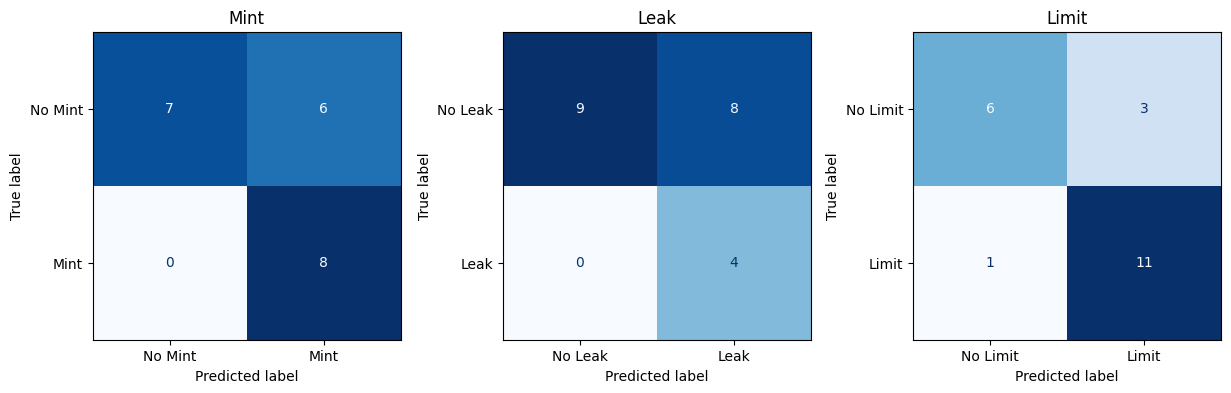

In [167]:
y_pred = tuned_gru_model.predict(X_test)
thresholds, _ = tune_thresholds(y_test_filtered, y_pred)

y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_test_filtered, y_pred)

### Graph

In [168]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_channels)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

#### Transaction

##### Load Data

In [169]:
graph_feature = load_feature('txn_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'txn.pkl'), 'rb'))

In [170]:
train_dataset, test_dataset = [], []
y_train_filtered, y_test_filtered = [], []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        y_train_filtered.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        y_test_filtered.append(y.loc[address])

    if i < 10:
        print(data)

Data(edge_index=[2, 1], tx_hash=[1], label=[1], gas=[1], num_nodes=2, x=[2, 6], y=[1, 3])
Data(edge_index=[2, 13], tx_hash=[13], label=[13], gas=[13], num_nodes=14, x=[14, 6], y=[1, 3])
Data(edge_index=[2, 65], tx_hash=[65], label=[65], gas=[65], num_nodes=66, x=[66, 6], y=[1, 3])
Data(edge_index=[2, 56], tx_hash=[56], label=[56], gas=[56], num_nodes=57, x=[57, 6], y=[1, 3])
Data(edge_index=[2, 252], tx_hash=[252], label=[252], gas=[252], num_nodes=253, x=[253, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])
Data(edge_index=[2, 5869], tx_hash=[5869], label=[5869], gas=[5869], num_nodes=5870, x=[5870, 6], y=[1, 3])
Data(edge_index=[2, 944], tx_hash=[944], label=[944], gas=[944], num_nodes=945, x=[945, 6], y=[1, 3])
Data(edge_index=[2, 58], tx_hash=[58], label=[58], gas=[58], num_nodes=59, x=[59, 6], y=[1, 3])
Data(edge_index=[2, 2], tx_hash=[2], label=[2], gas=[2], num_nodes=3, x=[3, 6], y=[1, 3])


In [171]:
len(train_dataset), len(test_dataset)

(26, 11)

In [172]:
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

##### Tuning

In [173]:
epochs = 30

In [174]:
def objective(trial):
    # Tune hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)

    # Model setup
    model = GCN(in_channels=graph_feature.shape[1], hidden=hidden_dim, out_channels=len(label_cols), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    best_thresholds, _ = tune_thresholds(y_true, y_pred)
    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_true, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 18:02:28,105] A new study created in memory with name: no-name-566f37bb-2333-484a-9e8c-543c29a6e84c


Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:02:41,600] Trial 0 finished with value: 0.2169312169312169 and parameters: {'hidden_dim': 236, 'lr': 9.267026523511717e-06, 'dropout': 0.32812547202027925}. Best is trial 0 with value: 0.2169312169312169.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:02:48,443] Trial 1 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 132, 'lr': 8.623776484660009e-06, 'dropout': 0.24889375351522053}. Best is trial 0 with value: 0.2169312169312169.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000


[I 2025-07-28 18:03:14,270] Trial 2 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 200, 'lr': 7.074246798695302e-05, 'dropout': 0.7923268568565422}. Best is trial 0 with value: 0.2169312169312169.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:03:25,275] Trial 3 finished with value: 0.24338624338624337 and parameters: {'hidden_dim': 183, 'lr': 7.236246291839641e-05, 'dropout': 0.06682376674487082}. Best is trial 3 with value: 0.24338624338624337.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000


[I 2025-07-28 18:03:40,427] Trial 4 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 256, 'lr': 2.275046809965146e-05, 'dropout': 0.18356554890016855}. Best is trial 3 with value: 0.24338624338624337.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:03:50,284] Trial 5 finished with value: 0.31746031746031744 and parameters: {'hidden_dim': 168, 'lr': 6.061410957695959e-05, 'dropout': 0.17366757027478485}. Best is trial 5 with value: 0.31746031746031744.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:04:20,877] Trial 6 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 254, 'lr': 0.001681257919080855, 'dropout': 0.5945664244552756}. Best is trial 5 with value: 0.31746031746031744.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:04:25,434] Trial 7 finished with value: 0.22857142857142856 and parameters: {'hidden_dim': 72, 'lr': 0.0056541843447404485, 'dropout': 0.4658233844815898}. Best is trial 5 with value: 0.31746031746031744.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.6667


[I 2025-07-28 18:05:25,215] Trial 8 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 236, 'lr': 2.658373380373318e-06, 'dropout': 0.42860479974373294}. Best is trial 8 with value: 0.36507936507936506.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:05:29,756] Trial 9 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 70, 'lr': 5.017680816486004e-05, 'dropout': 0.11894400243849318}. Best is trial 8 with value: 0.36507936507936506.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:05:36,087] Trial 10 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 121, 'lr': 1.5033105466193482e-06, 'dropout': 0.49600833797024213}. Best is trial 8 with value: 0.36507936507936506.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.5000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:05:51,418] Trial 11 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 185, 'lr': 0.0006885649023875891, 'dropout': 0.35396072246432475}. Best is trial 8 with value: 0.36507936507936506.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:06:04,276] Trial 12 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 211, 'lr': 1.3422836201193996e-06, 'dropout': 0.6666762244868931}. Best is trial 8 with value: 0.36507936507936506.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:06:18,468] Trial 13 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 157, 'lr': 0.00044258869648665757, 'dropout': 0.25651919353427344}. Best is trial 8 with value: 0.36507936507936506.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:06:24,226] Trial 14 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 111, 'lr': 5.394989650192281e-06, 'dropout': 0.02639453483271753}. Best is trial 8 with value: 0.36507936507936506.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.5000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:06:27,214] Trial 15 finished with value: 0.35714285714285715 and parameters: {'hidden_dim': 38, 'lr': 0.0003667328693855342, 'dropout': 0.4443691351649828}. Best is trial 8 with value: 0.36507936507936506.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:06:31,367] Trial 16 finished with value: 0.2962962962962963 and parameters: {'hidden_dim': 53, 'lr': 0.00023667636450138888, 'dropout': 0.4963339674154186}. Best is trial 8 with value: 0.36507936507936506.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:06:34,584] Trial 17 finished with value: 0.0 and parameters: {'hidden_dim': 38, 'lr': 0.0030599925879855956, 'dropout': 0.5809690526501354}. Best is trial 8 with value: 0.36507936507936506.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:06:40,051] Trial 18 finished with value: 0.22857142857142856 and parameters: {'hidden_dim': 99, 'lr': 0.00018482688070026616, 'dropout': 0.42396604803268306}. Best is trial 8 with value: 0.36507936507936506.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:06:47,852] Trial 19 finished with value: 0.3703703703703704 and parameters: {'hidden_dim': 94, 'lr': 0.0007107407254226668, 'dropout': 0.7157971879282674}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:06:53,879] Trial 20 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 94, 'lr': 0.0018840829772241287, 'dropout': 0.7758082964964822}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:06:59,402] Trial 21 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 73, 'lr': 0.0008298348558748613, 'dropout': 0.6706878271050436}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.01, Best f1 = 0.5000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:07:02,902] Trial 22 finished with value: 0.35714285714285715 and parameters: {'hidden_dim': 39, 'lr': 0.0003252915914646621, 'dropout': 0.5770580785853152}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:07:11,115] Trial 23 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 142, 'lr': 0.007638765983016869, 'dropout': 0.3835365854717746}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:07:16,343] Trial 24 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 89, 'lr': 0.00013253770483203202, 'dropout': 0.7052029539666128}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:07:29,798] Trial 25 finished with value: 0.2169312169312169 and parameters: {'hidden_dim': 226, 'lr': 2.5675743300371883e-05, 'dropout': 0.29858475076430374}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:07:34,486] Trial 26 finished with value: 0.0 and parameters: {'hidden_dim': 54, 'lr': 0.0011629922541897104, 'dropout': 0.5289057379246752}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:07:37,187] Trial 27 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 32, 'lr': 0.0005458197552217363, 'dropout': 0.41191165010985076}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:07:40,533] Trial 28 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 56, 'lr': 3.3396367866800273e-06, 'dropout': 0.44263420802135983}. Best is trial 19 with value: 0.3703703703703704.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.4000


[I 2025-07-28 18:07:46,423] Trial 29 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 112, 'lr': 2.389470788972412e-05, 'dropout': 0.3175630520777562}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:07:55,320] Trial 30 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 156, 'lr': 0.0034334334539529755, 'dropout': 0.6193427717070821}. Best is trial 19 with value: 0.3703703703703704.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:07:58,733] Trial 31 finished with value: 0.38181818181818183 and parameters: {'hidden_dim': 45, 'lr': 0.00031808112432840603, 'dropout': 0.5558298363639781}. Best is trial 31 with value: 0.38181818181818183.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:08:04,055] Trial 32 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 82, 'lr': 0.00015748861814072842, 'dropout': 0.735975115856625}. Best is trial 31 with value: 0.38181818181818183.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:08:08,148] Trial 33 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 60, 'lr': 0.0003271059684355928, 'dropout': 0.5385415585467336}. Best is trial 31 with value: 0.38181818181818183.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:08:20,914] Trial 34 finished with value: 0.0 and parameters: {'hidden_dim': 134, 'lr': 0.0010689331463495872, 'dropout': 0.6383953660746267}. Best is trial 31 with value: 0.38181818181818183.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:08:24,391] Trial 35 finished with value: 0.2638888888888889 and parameters: {'hidden_dim': 45, 'lr': 9.353469756713536e-06, 'dropout': 0.37568741807625927}. Best is trial 31 with value: 0.38181818181818183.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:08:55,773] Trial 36 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 237, 'lr': 0.0002731216634883098, 'dropout': 0.5506511638371774}. Best is trial 31 with value: 0.38181818181818183.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:09:04,939] Trial 37 finished with value: 0.07407407407407407 and parameters: {'hidden_dim': 103, 'lr': 3.9644919673515947e-05, 'dropout': 0.4705521879868124}. Best is trial 31 with value: 0.38181818181818183.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:09:09,756] Trial 38 finished with value: 0.0 and parameters: {'hidden_dim': 84, 'lr': 1.2920006599499411e-05, 'dropout': 0.7978822699061503}. Best is trial 31 with value: 0.38181818181818183.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:09:13,699] Trial 39 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 67, 'lr': 8.796440229174142e-05, 'dropout': 0.7280154841526298}. Best is trial 39 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:09:20,598] Trial 40 finished with value: 0.0 and parameters: {'hidden_dim': 71, 'lr': 3.1247564704703875e-06, 'dropout': 0.7046687321136035}. Best is trial 39 with value: 0.4222222222222222.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:09:25,189] Trial 41 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 46, 'lr': 9.761855168348623e-05, 'dropout': 0.7416291679490086}. Best is trial 39 with value: 0.4222222222222222.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:09:35,277] Trial 42 finished with value: 0.2916666666666667 and parameters: {'hidden_dim': 65, 'lr': 7.725287642031517e-05, 'dropout': 0.6297169849876084}. Best is trial 39 with value: 0.4222222222222222.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:09:55,840] Trial 43 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 189, 'lr': 0.00046085900444272173, 'dropout': 0.7493239540844042}. Best is trial 39 with value: 0.4222222222222222.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:09:59,494] Trial 44 finished with value: 0.38181818181818183 and parameters: {'hidden_dim': 48, 'lr': 0.0024617704938162104, 'dropout': 0.49837317028089484}. Best is trial 39 with value: 0.4222222222222222.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:10:04,395] Trial 45 finished with value: 0.27705627705627706 and parameters: {'hidden_dim': 76, 'lr': 0.002382286083333056, 'dropout': 0.5133825020469105}. Best is trial 39 with value: 0.4222222222222222.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:10:15,161] Trial 46 finished with value: 0.0 and parameters: {'hidden_dim': 170, 'lr': 0.004669083477409674, 'dropout': 0.6813583930831317}. Best is trial 39 with value: 0.4222222222222222.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:10:19,228] Trial 47 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 63, 'lr': 0.0014682282586400814, 'dropout': 0.6090147246842645}. Best is trial 39 with value: 0.4222222222222222.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:10:39,272] Trial 48 finished with value: 0.0 and parameters: {'hidden_dim': 207, 'lr': 0.0007094828779158258, 'dropout': 0.4769617326857387}. Best is trial 39 with value: 0.4222222222222222.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250


[I 2025-07-28 18:10:42,524] Trial 49 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 47, 'lr': 0.009774998268289226, 'dropout': 0.3377992574126937}. Best is trial 39 with value: 0.4222222222222222.


Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:10:49,326] Trial 50 finished with value: 0.3703703703703704 and parameters: {'hidden_dim': 120, 'lr': 1.4638664894325821e-05, 'dropout': 0.1798656733158752}. Best is trial 39 with value: 0.4222222222222222.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:10:56,258] Trial 51 finished with value: 0.46388888888888885 and parameters: {'hidden_dim': 125, 'lr': 1.976341275345211e-06, 'dropout': 0.17598491045728196}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.6667


[I 2025-07-28 18:11:02,881] Trial 52 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 120, 'lr': 1.7780433085920766e-06, 'dropout': 0.14534886825641952}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.5000


[I 2025-07-28 18:11:09,300] Trial 53 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 125, 'lr': 4.561653221185283e-06, 'dropout': 0.2321828345599802}. Best is trial 51 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:11:16,450] Trial 54 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 108, 'lr': 1.021840400590418e-05, 'dropout': 0.060808677615089235}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:11:21,931] Trial 55 finished with value: 0.42063492063492064 and parameters: {'hidden_dim': 97, 'lr': 1.095631190750491e-06, 'dropout': 0.21244958666891456}. Best is trial 51 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250


[I 2025-07-28 18:11:28,444] Trial 56 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 93, 'lr': 1.0562100450340525e-06, 'dropout': 0.26889986885297634}. Best is trial 51 with value: 0.46388888888888885.


Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:11:33,526] Trial 57 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 84, 'lr': 1.8926546300987823e-06, 'dropout': 0.10022564966307494}. Best is trial 51 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:11:37,672] Trial 58 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 76, 'lr': 4.733956997367513e-06, 'dropout': 0.15576868357394674}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.4000


[I 2025-07-28 18:11:44,308] Trial 59 finished with value: 0.22857142857142856 and parameters: {'hidden_dim': 97, 'lr': 1.1781942062327945e-06, 'dropout': 0.19624814575664354}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:11:49,627] Trial 60 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 104, 'lr': 2.3102884066669506e-06, 'dropout': 0.2269138787339461}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:11:56,563] Trial 61 finished with value: 0.12962962962962962 and parameters: {'hidden_dim': 116, 'lr': 1.5814420196905928e-05, 'dropout': 0.1978531085342275}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:12:04,183] Trial 62 finished with value: 0.46388888888888885 and parameters: {'hidden_dim': 133, 'lr': 6.5843185489677095e-06, 'dropout': 0.01741499319767914}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.4000


[I 2025-07-28 18:12:11,720] Trial 63 finished with value: 0.35555555555555557 and parameters: {'hidden_dim': 138, 'lr': 5.861893298305549e-06, 'dropout': 0.08768963208885047}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:12:18,782] Trial 64 finished with value: 0.46388888888888885 and parameters: {'hidden_dim': 128, 'lr': 1.5427936687451766e-06, 'dropout': 0.019211745802176657}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:12:25,909] Trial 65 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 148, 'lr': 1.4315999323780526e-06, 'dropout': 0.009588892021692275}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:12:32,954] Trial 66 finished with value: 0.0 and parameters: {'hidden_dim': 127, 'lr': 7.0921368220815e-06, 'dropout': 0.045872860702795934}. Best is trial 51 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:12:40,290] Trial 67 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 147, 'lr': 2.462576191549354e-06, 'dropout': 0.12815932704210892}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:12:49,248] Trial 68 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 158, 'lr': 3.6330264746695557e-06, 'dropout': 0.03455207960231474}. Best is trial 51 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:12:55,938] Trial 69 finished with value: 0.3666666666666667 and parameters: {'hidden_dim': 130, 'lr': 3.650153858972605e-05, 'dropout': 0.002144943827553933}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:12:59,580] Trial 70 finished with value: 0.2638888888888889 and parameters: {'hidden_dim': 36, 'lr': 1.6463399722962887e-06, 'dropout': 0.08837395303019246}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:13:02,531] Trial 71 finished with value: 0.3511904761904762 and parameters: {'hidden_dim': 48, 'lr': 1.021726433389336e-06, 'dropout': 0.7630450166607144}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:13:13,192] Trial 72 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 138, 'lr': 0.0010824407725409447, 'dropout': 0.5565241607318923}. Best is trial 51 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:13:18,835] Trial 73 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 112, 'lr': 0.00022369521985505527, 'dropout': 0.6925598624707101}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:13:23,026] Trial 74 finished with value: 0.0 and parameters: {'hidden_dim': 58, 'lr': 2.211172825838108e-06, 'dropout': 0.6522009537101707}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:13:27,265] Trial 75 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 67, 'lr': 0.00013527574465286413, 'dropout': 0.28889310998034}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:13:31,775] Trial 76 finished with value: 0.36507936507936506 and parameters: {'hidden_dim': 90, 'lr': 3.765678197435587e-06, 'dropout': 0.7252749784477074}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:13:38,881] Trial 77 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 101, 'lr': 0.000571034293321384, 'dropout': 0.38873279949668904}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:13:43,024] Trial 78 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 53, 'lr': 0.0015632413697790931, 'dropout': 0.353501448267906}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:13:55,393] Trial 79 finished with value: 0.09523809523809523 and parameters: {'hidden_dim': 154, 'lr': 0.0025809988716348, 'dropout': 0.590247116464985}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.5000


[I 2025-07-28 18:14:04,259] Trial 80 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 165, 'lr': 2.9049309108104475e-06, 'dropout': 0.7817467132679452}. Best is trial 51 with value: 0.46388888888888885.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:14:12,467] Trial 81 finished with value: 0.4222222222222222 and parameters: {'hidden_dim': 122, 'lr': 9.348627150266617e-05, 'dropout': 0.16327518617765396}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:14:19,418] Trial 82 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 132, 'lr': 5.5027029853770796e-05, 'dropout': 0.1101950480453866}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:14:28,983] Trial 83 finished with value: 0.2814814814814815 and parameters: {'hidden_dim': 116, 'lr': 8.928401403555308e-05, 'dropout': 0.07684640017112665}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:14:35,048] Trial 84 finished with value: 0.0 and parameters: {'hidden_dim': 123, 'lr': 0.00011353187986073044, 'dropout': 0.061198161463785816}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250


[I 2025-07-28 18:14:40,068] Trial 85 finished with value: 0.0 and parameters: {'hidden_dim': 81, 'lr': 0.00020722412017654677, 'dropout': 0.15247205874301842}. Best is trial 51 with value: 0.46388888888888885.


Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:14:47,697] Trial 86 finished with value: 0.0 and parameters: {'hidden_dim': 140, 'lr': 0.00038746550447093657, 'dropout': 0.13196659431314903}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:14:53,744] Trial 87 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 108, 'lr': 4.157844796087798e-05, 'dropout': 0.022763416500869077}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:14:56,778] Trial 88 finished with value: 0.1818181818181818 and parameters: {'hidden_dim': 42, 'lr': 0.0052619847300624046, 'dropout': 0.23521539584766427}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:15:02,857] Trial 89 finished with value: 0.20833333333333334 and parameters: {'hidden_dim': 128, 'lr': 6.527282328995044e-05, 'dropout': 0.2078721165819672}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250


[I 2025-07-28 18:15:06,021] Trial 90 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 32, 'lr': 0.0008743339684630063, 'dropout': 0.4530149283246356}. Best is trial 51 with value: 0.46388888888888885.


Label 0: Best threshold = 0.01, Best f1 = 0.4444
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:15:11,829] Trial 91 finished with value: 0.3703703703703704 and parameters: {'hidden_dim': 117, 'lr': 1.692036416915702e-05, 'dropout': 0.17123071280660093}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:15:17,630] Trial 92 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 105, 'lr': 0.00027239880811447847, 'dropout': 0.25489465608371065}. Best is trial 51 with value: 0.46388888888888885.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.01, Best f1 = 0.4000


[I 2025-07-28 18:15:25,025] Trial 93 finished with value: 0.4845238095238095 and parameters: {'hidden_dim': 145, 'lr': 1.4282342416952332e-06, 'dropout': 0.18513125798637062}. Best is trial 93 with value: 0.4845238095238095.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286


[I 2025-07-28 18:15:32,326] Trial 94 finished with value: 0.05555555555555555 and parameters: {'hidden_dim': 144, 'lr': 1.2531274903379074e-06, 'dropout': 0.2900553883106112}. Best is trial 93 with value: 0.4845238095238095.


Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:15:38,878] Trial 95 finished with value: 0.14285714285714285 and parameters: {'hidden_dim': 137, 'lr': 1.4798725060574244e-06, 'dropout': 0.50008034077032}. Best is trial 93 with value: 0.4845238095238095.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:15:46,311] Trial 96 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 134, 'lr': 2.9680838821872158e-05, 'dropout': 0.7124475568968514}. Best is trial 93 with value: 0.4845238095238095.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:15:49,870] Trial 97 finished with value: 0.0 and parameters: {'hidden_dim': 60, 'lr': 0.00016760418415477424, 'dropout': 0.42840425112755415}. Best is trial 93 with value: 0.4845238095238095.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:15:58,219] Trial 98 finished with value: 0.25555555555555554 and parameters: {'hidden_dim': 151, 'lr': 1.9879535385379156e-06, 'dropout': 0.1661856933936084}. Best is trial 93 with value: 0.4845238095238095.


Label 2: Best threshold = 0.00, Best f1 = 0.6250
Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667


[I 2025-07-28 18:16:06,448] Trial 99 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 161, 'lr': 0.003784848354752428, 'dropout': 0.21660355351291233}. Best is trial 93 with value: 0.4845238095238095.


Label 2: Best threshold = 0.01, Best f1 = 0.6667
Best Params: {'hidden_dim': 145, 'lr': 1.4282342416952332e-06, 'dropout': 0.18513125798637062}
Best Score: 0.4845238095238095


##### Final

Label 0: Best threshold = 0.00, Best f1 = 0.4286
Label 1: Best threshold = 0.00, Best f1 = 0.1667
Label 2: Best threshold = 0.00, Best f1 = 0.6250
              precision    recall  f1-score   support

        Mint       0.00      0.00      0.00         3
        Leak       0.00      0.00      0.00         1
       Limit       0.45      1.00      0.62         5

   micro avg       0.45      0.56      0.50         9
   macro avg       0.15      0.33      0.21         9
weighted avg       0.25      0.56      0.35         9
 samples avg       0.45      0.27      0.33         9



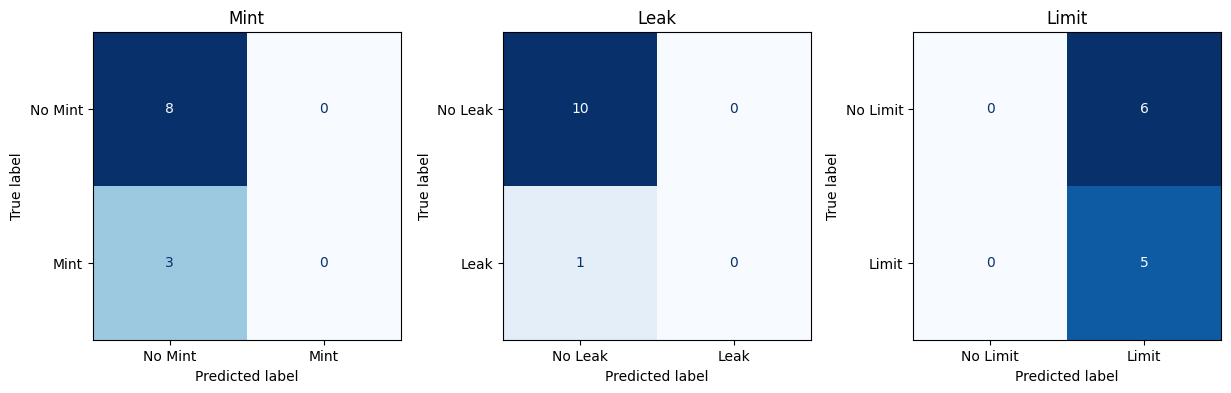

In [175]:
# Model setup
tuned_txn_gcn_model = GCN(in_channels=graph_feature.shape[1], hidden=study.best_params['hidden_dim'], out_channels=len(label_cols), dropout=study.best_params['dropout'])
optimizer = torch.optim.Adam(tuned_txn_gcn_model.parameters(), lr=study.best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training
tuned_txn_gcn_model.train()
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        out = tuned_txn_gcn_model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()

# Validation
tuned_txn_gcn_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        out = tuned_txn_gcn_model(batch)
        preds = (torch.sigmoid(out) > 0.5).cpu().int()
        y_true.append(batch.y.cpu())
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

best_thresholds, _ = tune_thresholds(y_true, y_pred)
y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

#### Control Flow

##### Load Data

In [176]:
graph_feature = load_feature('cfg_graph_features.csv')
graph_feature.index = graph_feature.index.str.lower()
graphs = pickle.load(open(os.path.join(PATH, 'cfg.pkl'), 'rb'))

In [177]:
train_dataset, test_dataset = [], []
y_train_filtered, y_test_filtered = [], []
for i, (address, graph_data) in enumerate(graphs.items()):
    feature = graph_feature.loc[address]
    data = from_networkx(graph_data)

    data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
    data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension

    if address in train_idx:
        train_dataset.append(data)
        y_train_filtered.append(y.loc[address])
    elif address in test_idx:
        test_dataset.append(data)
        y_test_filtered.append(y.loc[address])

    if i < 10:
        print(data)

Data(edge_index=[2, 118], num_nodes=155, x=[155, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=194, x=[194, 6], y=[1, 3])
Data(edge_index=[2, 178], num_nodes=339, x=[339, 6], y=[1, 3])
Data(edge_index=[2, 78], num_nodes=113, x=[113, 6], y=[1, 3])
Data(edge_index=[2, 211], num_nodes=303, x=[303, 6], y=[1, 3])
Data(edge_index=[2, 158], num_nodes=377, x=[377, 6], y=[1, 3])
Data(edge_index=[2, 365], num_nodes=683, x=[683, 6], y=[1, 3])
Data(edge_index=[2, 137], num_nodes=215, x=[215, 6], y=[1, 3])
Data(edge_index=[2, 96], num_nodes=192, x=[192, 6], y=[1, 3])
Data(edge_index=[2, 4], num_nodes=584, x=[584, 6], y=[1, 3])


In [178]:
len(train_dataset), len(test_dataset)

(47, 20)

In [179]:
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

##### Tuning

In [180]:
epochs = 30

In [181]:
def objective(trial):
    # Tune hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)

    # Model setup
    model = GCN(in_channels=graph_feature.shape[1], hidden=hidden_dim, out_channels=len(label_cols), dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Training
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).cpu().int()
            y_true.append(batch.y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    best_thresholds, _ = tune_thresholds(y_true, y_pred)
    y_pred = (y_pred > thresholds).astype(int)

    return f1_score(y_true, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-07-28 18:16:15,358] A new study created in memory with name: no-name-63a81165-b309-418e-b37b-c1362c947da8


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.4211


[I 2025-07-28 18:16:25,396] Trial 0 finished with value: 0.2884990253411306 and parameters: {'hidden_dim': 215, 'lr': 0.0004423368489363631, 'dropout': 0.4672447367714587}. Best is trial 0 with value: 0.2884990253411306.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:16:28,119] Trial 1 finished with value: 0.19444444444444442 and parameters: {'hidden_dim': 41, 'lr': 8.812993664153751e-06, 'dropout': 0.7302618086142474}. Best is trial 0 with value: 0.2884990253411306.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5333
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:16:38,306] Trial 2 finished with value: 0.33464052287581697 and parameters: {'hidden_dim': 250, 'lr': 0.00548480573626541, 'dropout': 0.7379378345964375}. Best is trial 2 with value: 0.33464052287581697.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:16:42,832] Trial 3 finished with value: 0.33730158730158727 and parameters: {'hidden_dim': 111, 'lr': 0.00019747777812999676, 'dropout': 0.07061112065890143}. Best is trial 3 with value: 0.33730158730158727.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 18:16:46,032] Trial 4 finished with value: 0.26282051282051283 and parameters: {'hidden_dim': 62, 'lr': 0.0005702494850113047, 'dropout': 0.48633515072080896}. Best is trial 3 with value: 0.33730158730158727.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:16:53,535] Trial 5 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 160, 'lr': 0.00016052966087013338, 'dropout': 0.3252388033756525}. Best is trial 3 with value: 0.33730158730158727.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:16:56,551] Trial 6 finished with value: 0.3849607182940516 and parameters: {'hidden_dim': 36, 'lr': 3.827640197228908e-06, 'dropout': 0.3680257476351875}. Best is trial 6 with value: 0.3849607182940516.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:17:00,550] Trial 7 finished with value: 0.301994301994302 and parameters: {'hidden_dim': 100, 'lr': 0.0036582742113569263, 'dropout': 0.1224588854231513}. Best is trial 6 with value: 0.3849607182940516.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:17:08,468] Trial 8 finished with value: 0.06060606060606061 and parameters: {'hidden_dim': 198, 'lr': 5.2726459979188686e-05, 'dropout': 0.31782355343215285}. Best is trial 6 with value: 0.3849607182940516.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:17:12,230] Trial 9 finished with value: 0.19999999999999998 and parameters: {'hidden_dim': 82, 'lr': 1.3191296868342629e-05, 'dropout': 0.12994046892535033}. Best is trial 6 with value: 0.3849607182940516.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:17:15,124] Trial 10 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 32, 'lr': 1.2859675878855392e-06, 'dropout': 0.5804058124627278}. Best is trial 6 with value: 0.3849607182940516.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:17:20,298] Trial 11 finished with value: 0.19444444444444442 and parameters: {'hidden_dim': 117, 'lr': 1.8444219235267195e-06, 'dropout': 0.017230559818203213}. Best is trial 6 with value: 0.3849607182940516.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:17:25,423] Trial 12 finished with value: 0.2236842105263158 and parameters: {'hidden_dim': 144, 'lr': 1.8787333858402016e-05, 'dropout': 0.21938929370398022}. Best is trial 6 with value: 0.3849607182940516.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:17:30,812] Trial 13 finished with value: 0.2877846790890269 and parameters: {'hidden_dim': 124, 'lr': 9.26296384399478e-05, 'dropout': 0.04464674712292516}. Best is trial 6 with value: 0.3849607182940516.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:17:34,336] Trial 14 finished with value: 0.32070707070707066 and parameters: {'hidden_dim': 75, 'lr': 0.0007325569296510237, 'dropout': 0.23893297119725163}. Best is trial 6 with value: 0.3849607182940516.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:17:40,524] Trial 15 finished with value: 0.24242424242424243 and parameters: {'hidden_dim': 162, 'lr': 4.395307708521611e-06, 'dropout': 0.4013800334582683}. Best is trial 6 with value: 0.3849607182940516.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5833
Label 1: Best threshold = 0.01, Best f1 = 0.3478
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:17:44,225] Trial 16 finished with value: 0.3103864734299517 and parameters: {'hidden_dim': 61, 'lr': 4.14397296196623e-05, 'dropout': 0.6107668703426338}. Best is trial 6 with value: 0.3849607182940516.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:17:48,224] Trial 17 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 98, 'lr': 0.0002055042699317899, 'dropout': 0.17621468415650843}. Best is trial 6 with value: 0.3849607182940516.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:17:55,979] Trial 18 finished with value: 0.43076923076923074 and parameters: {'hidden_dim': 189, 'lr': 0.0016882775270241775, 'dropout': 0.3123146034238664}. Best is trial 18 with value: 0.43076923076923074.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5333
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:18:02,616] Trial 19 finished with value: 0.3181286549707602 and parameters: {'hidden_dim': 188, 'lr': 0.0023931577098859577, 'dropout': 0.2801149868335995}. Best is trial 18 with value: 0.43076923076923074.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:18:13,313] Trial 20 finished with value: 0.1568627450980392 and parameters: {'hidden_dim': 255, 'lr': 0.0013591674484179062, 'dropout': 0.3741516784834754}. Best is trial 18 with value: 0.43076923076923074.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:18:22,341] Trial 21 finished with value: 0.19047619047619047 and parameters: {'hidden_dim': 219, 'lr': 0.000274485796155081, 'dropout': 0.4489648233394914}. Best is trial 18 with value: 0.43076923076923074.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:18:28,815] Trial 22 finished with value: 0.3333333333333333 and parameters: {'hidden_dim': 177, 'lr': 0.008043632167766213, 'dropout': 0.5600839837617084}. Best is trial 18 with value: 0.43076923076923074.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:18:34,759] Trial 23 finished with value: 0.14035087719298245 and parameters: {'hidden_dim': 137, 'lr': 0.001175162590653069, 'dropout': 0.11051348633203018}. Best is trial 18 with value: 0.43076923076923074.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:18:39,260] Trial 24 finished with value: 0.23655913978494625 and parameters: {'hidden_dim': 109, 'lr': 3.446245558738618e-05, 'dropout': 0.3740179601972238}. Best is trial 18 with value: 0.43076923076923074.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:18:48,733] Trial 25 finished with value: 0.08333333333333333 and parameters: {'hidden_dim': 229, 'lr': 0.001785874777810094, 'dropout': 0.22638598032633483}. Best is trial 18 with value: 0.43076923076923074.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 18:18:54,842] Trial 26 finished with value: 0.47548500881834216 and parameters: {'hidden_dim': 163, 'lr': 9.427362996831929e-05, 'dropout': 0.3089735030961917}. Best is trial 26 with value: 0.47548500881834216.


Label 1: Best threshold = 0.01, Best f1 = 0.4000
Label 2: Best threshold = 0.01, Best f1 = 0.7407
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.4000


[I 2025-07-28 18:19:01,587] Trial 27 finished with value: 0.23589743589743592 and parameters: {'hidden_dim': 168, 'lr': 3.4638634690959755e-06, 'dropout': 0.3109693064145295}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 18:19:08,898] Trial 28 finished with value: 0.0 and parameters: {'hidden_dim': 197, 'lr': 9.21888043111752e-05, 'dropout': 0.5320082816124659}. Best is trial 26 with value: 0.47548500881834216.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:19:15,236] Trial 29 finished with value: 0.0 and parameters: {'hidden_dim': 142, 'lr': 7.231849543804424e-06, 'dropout': 0.43956649458891905}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.6000
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:19:22,562] Trial 30 finished with value: 0.3866666666666667 and parameters: {'hidden_dim': 208, 'lr': 0.0003586571560961686, 'dropout': 0.39201432661581437}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:19:31,073] Trial 31 finished with value: 0.16666666666666666 and parameters: {'hidden_dim': 210, 'lr': 0.00044161181992726184, 'dropout': 0.3952331618133031}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:19:40,454] Trial 32 finished with value: 0.2905982905982906 and parameters: {'hidden_dim': 230, 'lr': 0.0003685577419199139, 'dropout': 0.26393253780612014}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 18:19:47,235] Trial 33 finished with value: 0.11616161616161617 and parameters: {'hidden_dim': 181, 'lr': 0.000892498687428099, 'dropout': 0.5006106862076289}. Best is trial 26 with value: 0.47548500881834216.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:19:53,934] Trial 34 finished with value: 0.3235294117647059 and parameters: {'hidden_dim': 156, 'lr': 0.0028386758275368114, 'dropout': 0.6711589096612536}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5385
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:20:03,651] Trial 35 finished with value: 0.35232668566001896 and parameters: {'hidden_dim': 239, 'lr': 2.346951043677815e-05, 'dropout': 0.3180676122330317}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3478


[I 2025-07-28 18:20:11,865] Trial 36 finished with value: 0.40096618357487923 and parameters: {'hidden_dim': 213, 'lr': 0.00014451789447341134, 'dropout': 0.3559708688622211}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:20:20,344] Trial 37 finished with value: 0.24019607843137256 and parameters: {'hidden_dim': 203, 'lr': 0.00013412633565789716, 'dropout': 0.42399272793456094}. Best is trial 26 with value: 0.47548500881834216.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:20:28,583] Trial 38 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 213, 'lr': 7.234147110551383e-05, 'dropout': 0.7826082732278979}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:20:35,756] Trial 39 finished with value: 0.1568627450980392 and parameters: {'hidden_dim': 186, 'lr': 0.000276053335323423, 'dropout': 0.33257195126595857}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5333
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:20:45,468] Trial 40 finished with value: 0.3444444444444444 and parameters: {'hidden_dim': 242, 'lr': 0.004833860869184666, 'dropout': 0.1739436454979646}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:20:52,650] Trial 41 finished with value: 0.3619047619047619 and parameters: {'hidden_dim': 193, 'lr': 0.00012383033815715008, 'dropout': 0.35567675459556103}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:20:59,924] Trial 42 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 173, 'lr': 5.3541438099656787e-05, 'dropout': 0.2881767923884091}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:21:08,803] Trial 43 finished with value: 0.38874680306905374 and parameters: {'hidden_dim': 220, 'lr': 0.0005464268964413359, 'dropout': 0.3546870388276197}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:21:17,237] Trial 44 finished with value: 0.3968253968253968 and parameters: {'hidden_dim': 225, 'lr': 0.0005544730923780676, 'dropout': 0.4748026817569719}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5263
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:21:26,267] Trial 45 finished with value: 0.2230576441102757 and parameters: {'hidden_dim': 222, 'lr': 0.000519940349136138, 'dropout': 0.47659234478816825}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5333
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:21:36,060] Trial 46 finished with value: 0.3846743295019157 and parameters: {'hidden_dim': 244, 'lr': 0.0007676636302535766, 'dropout': 0.19398146367252586}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.7500
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:21:45,761] Trial 47 finished with value: 0.44047619047619047 and parameters: {'hidden_dim': 227, 'lr': 0.00020686620397791593, 'dropout': 0.509861759049077}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 18:21:55,028] Trial 48 finished with value: 0.37973605789697745 and parameters: {'hidden_dim': 234, 'lr': 0.00022163419025280422, 'dropout': 0.5105178045550597}. Best is trial 26 with value: 0.47548500881834216.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5333
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:22:01,628] Trial 49 finished with value: 0.4282953761214631 and parameters: {'hidden_dim': 154, 'lr': 0.00018047778160114577, 'dropout': 0.6389243927201904}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:22:07,167] Trial 50 finished with value: 0.0 and parameters: {'hidden_dim': 152, 'lr': 0.00016768079587452088, 'dropout': 0.6571642329148446}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:22:12,762] Trial 51 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 127, 'lr': 6.992570100139e-05, 'dropout': 0.6213963951452459}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:22:19,162] Trial 52 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 166, 'lr': 0.00015966725266722045, 'dropout': 0.553337461689494}. Best is trial 26 with value: 0.47548500881834216.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 18:22:27,639] Trial 53 finished with value: 0.43101810917902866 and parameters: {'hidden_dim': 205, 'lr': 0.0003031518813448662, 'dropout': 0.4630627538849044}. Best is trial 26 with value: 0.47548500881834216.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:22:35,729] Trial 54 finished with value: 0.5205097570688969 and parameters: {'hidden_dim': 203, 'lr': 0.00010793186278649059, 'dropout': 0.7249834313004957}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:22:43,973] Trial 55 finished with value: 0.1111111111111111 and parameters: {'hidden_dim': 201, 'lr': 2.483805838723603e-05, 'dropout': 0.7061010458424977}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:22:51,533] Trial 56 finished with value: 0.4205128205128205 and parameters: {'hidden_dim': 183, 'lr': 0.00010371936320271049, 'dropout': 0.761531936255597}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:22:57,451] Trial 57 finished with value: 0.2561728395061728 and parameters: {'hidden_dim': 151, 'lr': 0.00027673953360837626, 'dropout': 0.7262309219945091}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:23:05,219] Trial 58 finished with value: 0.0784313725490196 and parameters: {'hidden_dim': 190, 'lr': 4.375780525148066e-05, 'dropout': 0.6039238579295491}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5600
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:23:10,323] Trial 59 finished with value: 0.37714285714285717 and parameters: {'hidden_dim': 132, 'lr': 7.38780321217653e-05, 'dropout': 0.636005695644729}. Best is trial 54 with value: 0.5205097570688969.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:23:17,378] Trial 60 finished with value: 0.37973605789697745 and parameters: {'hidden_dim': 171, 'lr': 0.0012377920711126756, 'dropout': 0.6924364222685893}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:23:24,168] Trial 61 finished with value: 0.0 and parameters: {'hidden_dim': 182, 'lr': 9.97752182920177e-05, 'dropout': 0.7771843454525291}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:23:32,417] Trial 62 finished with value: 0.11794871794871796 and parameters: {'hidden_dim': 204, 'lr': 0.00020467021595050406, 'dropout': 0.74773638021321}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3478


[I 2025-07-28 18:23:39,428] Trial 63 finished with value: 0.11594202898550725 and parameters: {'hidden_dim': 194, 'lr': 0.00010584950336317935, 'dropout': 0.7301679877755475}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:23:46,801] Trial 64 finished with value: 0.25925925925925924 and parameters: {'hidden_dim': 177, 'lr': 0.009257533394828247, 'dropout': 0.7564346494758547}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:23:52,844] Trial 65 finished with value: 0.1388888888888889 and parameters: {'hidden_dim': 164, 'lr': 5.580740828294115e-05, 'dropout': 0.7938152944973371}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:24:00,408] Trial 66 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 185, 'lr': 0.00035829207932786065, 'dropout': 0.5816283041158213}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:24:05,829] Trial 67 finished with value: 0.41617283950617284 and parameters: {'hidden_dim': 146, 'lr': 3.235009170505796e-05, 'dropout': 0.6835436497529046}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:24:12,379] Trial 68 finished with value: 0.2241215574548908 and parameters: {'hidden_dim': 160, 'lr': 0.0002500878873638252, 'dropout': 0.4196377885844549}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5600
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:24:19,630] Trial 69 finished with value: 0.3466666666666667 and parameters: {'hidden_dim': 198, 'lr': 0.0016850482138974566, 'dropout': 0.7067151687718899}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.01, Best f1 = 0.7692


[I 2025-07-28 18:24:26,673] Trial 70 finished with value: 0.25641025641025644 and parameters: {'hidden_dim': 176, 'lr': 1.001838904067426e-05, 'dropout': 0.6479992540868043}. Best is trial 54 with value: 0.5205097570688969.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:24:32,135] Trial 71 finished with value: 0.39259259259259255 and parameters: {'hidden_dim': 146, 'lr': 2.8838153904272424e-05, 'dropout': 0.682013342421424}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.7692
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:24:38,270] Trial 72 finished with value: 0.334841628959276 and parameters: {'hidden_dim': 137, 'lr': 8.239709161531718e-05, 'dropout': 0.7711197331228397}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:24:43,034] Trial 73 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 121, 'lr': 1.332323059569329e-05, 'dropout': 0.2588336329886751}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:24:49,832] Trial 74 finished with value: 0.0 and parameters: {'hidden_dim': 155, 'lr': 4.0046364087106535e-05, 'dropout': 0.5434064782322561}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 18:24:52,519] Trial 75 finished with value: 0.12222222222222223 and parameters: {'hidden_dim': 48, 'lr': 0.00011947558758081471, 'dropout': 0.5825672171963983}. Best is trial 54 with value: 0.5205097570688969.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:25:00,980] Trial 76 finished with value: 0.3000604960677556 and parameters: {'hidden_dim': 207, 'lr': 0.0001625818017104539, 'dropout': 0.5250879025127542}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 18:25:06,532] Trial 77 finished with value: 0.37373737373737376 and parameters: {'hidden_dim': 147, 'lr': 1.560884631742096e-05, 'dropout': 0.44903756769900005}. Best is trial 54 with value: 0.5205097570688969.


Label 1: Best threshold = 0.01, Best f1 = 0.5000
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:25:15,576] Trial 78 finished with value: 0.1728395061728395 and parameters: {'hidden_dim': 215, 'lr': 5.672035976733238e-05, 'dropout': 0.7179445912030733}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.01, Best f1 = 0.5385
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:25:22,495] Trial 79 finished with value: 0.1794871794871795 and parameters: {'hidden_dim': 169, 'lr': 0.00031598629996313255, 'dropout': 0.6696628793697457}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:25:27,796] Trial 80 finished with value: 0.15384615384615385 and parameters: {'hidden_dim': 109, 'lr': 0.00018992576558167368, 'dropout': 0.3360788561440816}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:25:35,373] Trial 81 finished with value: 0.13333333333333333 and parameters: {'hidden_dim': 210, 'lr': 0.00014922068765944987, 'dropout': 0.28655915976253515}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.4211


[I 2025-07-28 18:25:44,575] Trial 82 finished with value: 0.393912130754236 and parameters: {'hidden_dim': 228, 'lr': 8.912406931569184e-05, 'dropout': 0.2978672459621519}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:25:53,352] Trial 83 finished with value: 0.2222222222222222 and parameters: {'hidden_dim': 218, 'lr': 0.0001334380936927083, 'dropout': 0.3973900728528161}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:26:00,229] Trial 84 finished with value: 0.3633156966490299 and parameters: {'hidden_dim': 190, 'lr': 0.0004335315706864148, 'dropout': 0.3519650949145703}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:26:09,670] Trial 85 finished with value: 0.30617283950617286 and parameters: {'hidden_dim': 233, 'lr': 0.00011466121388889902, 'dropout': 0.24992313977367284}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:26:14,784] Trial 86 finished with value: 0.478395061728395 and parameters: {'hidden_dim': 140, 'lr': 6.396197413662296e-05, 'dropout': 0.49700616564343003}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:26:21,483] Trial 87 finished with value: 0.3668965517241379 and parameters: {'hidden_dim': 158, 'lr': 6.357161336335871e-05, 'dropout': 0.5068861351179945}. Best is trial 54 with value: 0.5205097570688969.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:26:26,630] Trial 88 finished with value: 0.4205128205128205 and parameters: {'hidden_dim': 135, 'lr': 4.339484247517266e-05, 'dropout': 0.46024896893512307}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 18:26:32,679] Trial 89 finished with value: 0.23407407407407407 and parameters: {'hidden_dim': 140, 'lr': 4.4253541148657993e-05, 'dropout': 0.45903552494774374}. Best is trial 54 with value: 0.5205097570688969.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:26:36,528] Trial 90 finished with value: 0.14814814814814814 and parameters: {'hidden_dim': 96, 'lr': 2.2197570512097425e-05, 'dropout': 0.48980663766200405}. Best is trial 54 with value: 0.5205097570688969.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:26:41,294] Trial 91 finished with value: 0.15384615384615385 and parameters: {'hidden_dim': 117, 'lr': 3.2396498289783166e-05, 'dropout': 0.4273173418141103}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:26:47,253] Trial 92 finished with value: 0.3950617283950617 and parameters: {'hidden_dim': 137, 'lr': 3.7512557672974534e-05, 'dropout': 0.7592478936529482}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:26:52,201] Trial 93 finished with value: 0.29971988795518206 and parameters: {'hidden_dim': 130, 'lr': 0.005889869788946039, 'dropout': 0.3781017306639071}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:26:58,568] Trial 94 finished with value: 0.21728395061728392 and parameters: {'hidden_dim': 150, 'lr': 4.7354282718198795e-05, 'dropout': 0.7393739418394832}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:27:08,168] Trial 95 finished with value: 0.2239316239316239 and parameters: {'hidden_dim': 249, 'lr': 8.661812145281828e-05, 'dropout': 0.488244715676937}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185


[I 2025-07-28 18:27:15,221] Trial 96 finished with value: 0.31321839080459773 and parameters: {'hidden_dim': 180, 'lr': 6.282929222440977e-05, 'dropout': 0.5683606952912825}. Best is trial 54 with value: 0.5205097570688969.


Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333


[I 2025-07-28 18:27:21,748] Trial 97 finished with value: 0.29721362229102166 and parameters: {'hidden_dim': 163, 'lr': 0.0009088862256852142, 'dropout': 0.4176520365465253}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3478
Label 2: Best threshold = 0.00, Best f1 = 0.7097


[I 2025-07-28 18:27:27,655] Trial 98 finished with value: 0.2640901771336554 and parameters: {'hidden_dim': 143, 'lr': 1.8508386202166536e-05, 'dropout': 0.4634851887980489}. Best is trial 54 with value: 0.5205097570688969.


Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.01, Best f1 = 0.3810


[I 2025-07-28 18:27:32,384] Trial 99 finished with value: 0.32844932844932845 and parameters: {'hidden_dim': 123, 'lr': 2.8547634903210487e-05, 'dropout': 0.6014815211200407}. Best is trial 54 with value: 0.5205097570688969.


Label 2: Best threshold = 0.00, Best f1 = 0.7097
Best Params: {'hidden_dim': 203, 'lr': 0.00010793186278649059, 'dropout': 0.7249834313004957}
Best Score: 0.5205097570688969


##### Final

Label 0: Best threshold = 0.00, Best f1 = 0.5185
Label 1: Best threshold = 0.00, Best f1 = 0.3333
Label 2: Best threshold = 0.00, Best f1 = 0.7097
              precision    recall  f1-score   support

        Mint       0.50      0.43      0.46         7
        Leak       0.09      0.25      0.13         4
       Limit       0.57      0.36      0.44        11

   micro avg       0.33      0.36      0.35        22
   macro avg       0.39      0.35      0.35        22
weighted avg       0.46      0.36      0.39        22
 samples avg       0.30      0.18      0.22        22



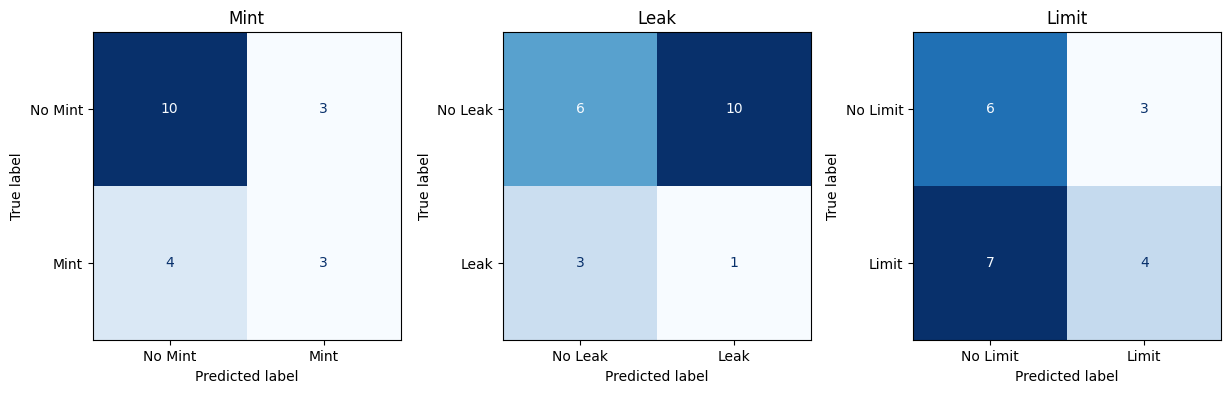

In [182]:
# Model setup
tuned_cfg_gcn_model = GCN(in_channels=graph_feature.shape[1], hidden=study.best_params['hidden_dim'], out_channels=len(label_cols), dropout=study.best_params['dropout'])
optimizer = torch.optim.Adam(tuned_cfg_gcn_model.parameters(), lr=study.best_params['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training
tuned_cfg_gcn_model.train()
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        out = tuned_cfg_gcn_model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()

# Validation
tuned_cfg_gcn_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        out = tuned_cfg_gcn_model(batch)
        preds = (torch.sigmoid(out) > 0.5).cpu().int()
        y_true.append(batch.y.cpu())
        y_pred.append(preds)

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

best_thresholds, _ = tune_thresholds(y_true, y_pred)
y_pred = (y_pred > thresholds).astype(int)
plot_confusion_matrix(y_true, y_pred)

## Fusion